# Импорты

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, functions
from pyspark.sql.types import *

# Block1 SparkApp

In [2]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [3]:
conf = SparkConf().set("spark.executor.instances", "2").set("spark.executor.cores", "1").set("spark.executor.memory", "1g")

In [4]:
sc = SparkContext(appName="Bekusov_spark", master="yarn")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 03:33:21 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


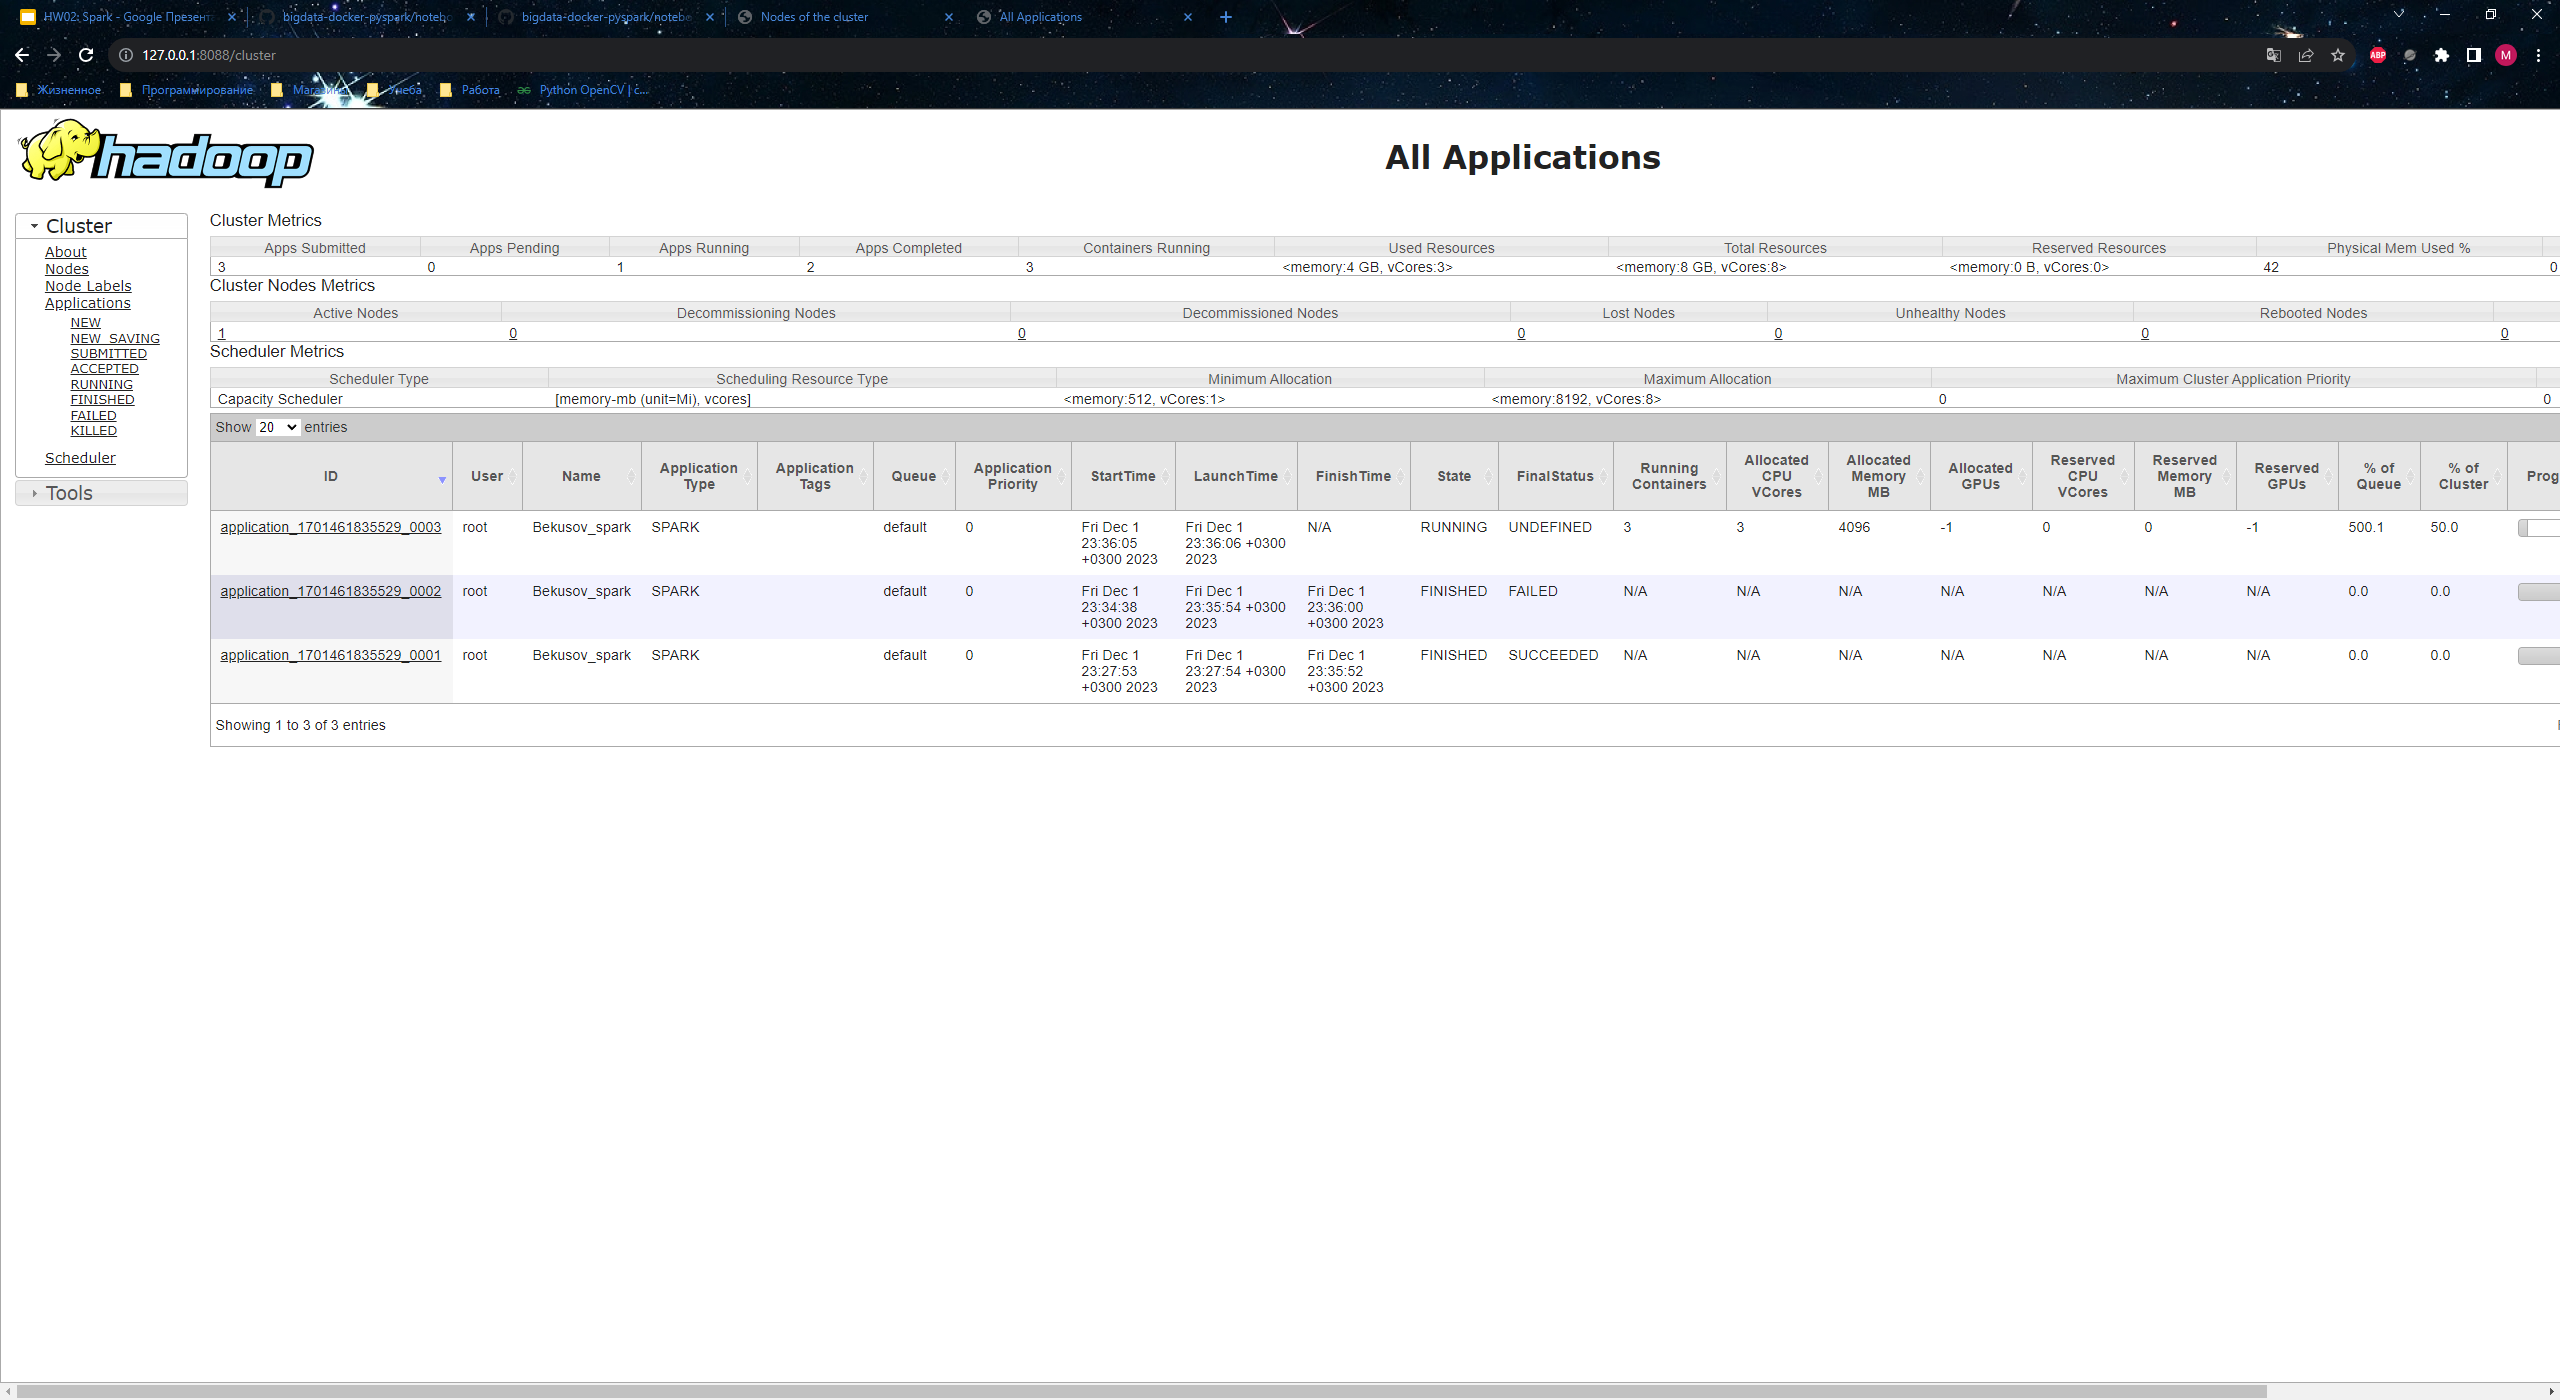

In [5]:
ls 

hadoop@  hadoop-3.3.6/  notebooks/


In [6]:
!hdfs dfs -rm -r ml-latest-small
!hdfs dfs -put notebooks/ml-latest-small/

Deleted ml-latest-small


### Прочтение и подсчет строчек в датасетах

In [7]:
ratings = sc.textFile("ml-latest-small/ratings.csv")
ratings_content = ratings.filter(lambda x: "userId" not in x)
ratings_content.count()

100836

In [8]:
tags = sc.textFile("ml-latest-small/tags.csv")
tags_content = tags.filter(lambda x: "userId" not in x)
tags_content.count()

3683

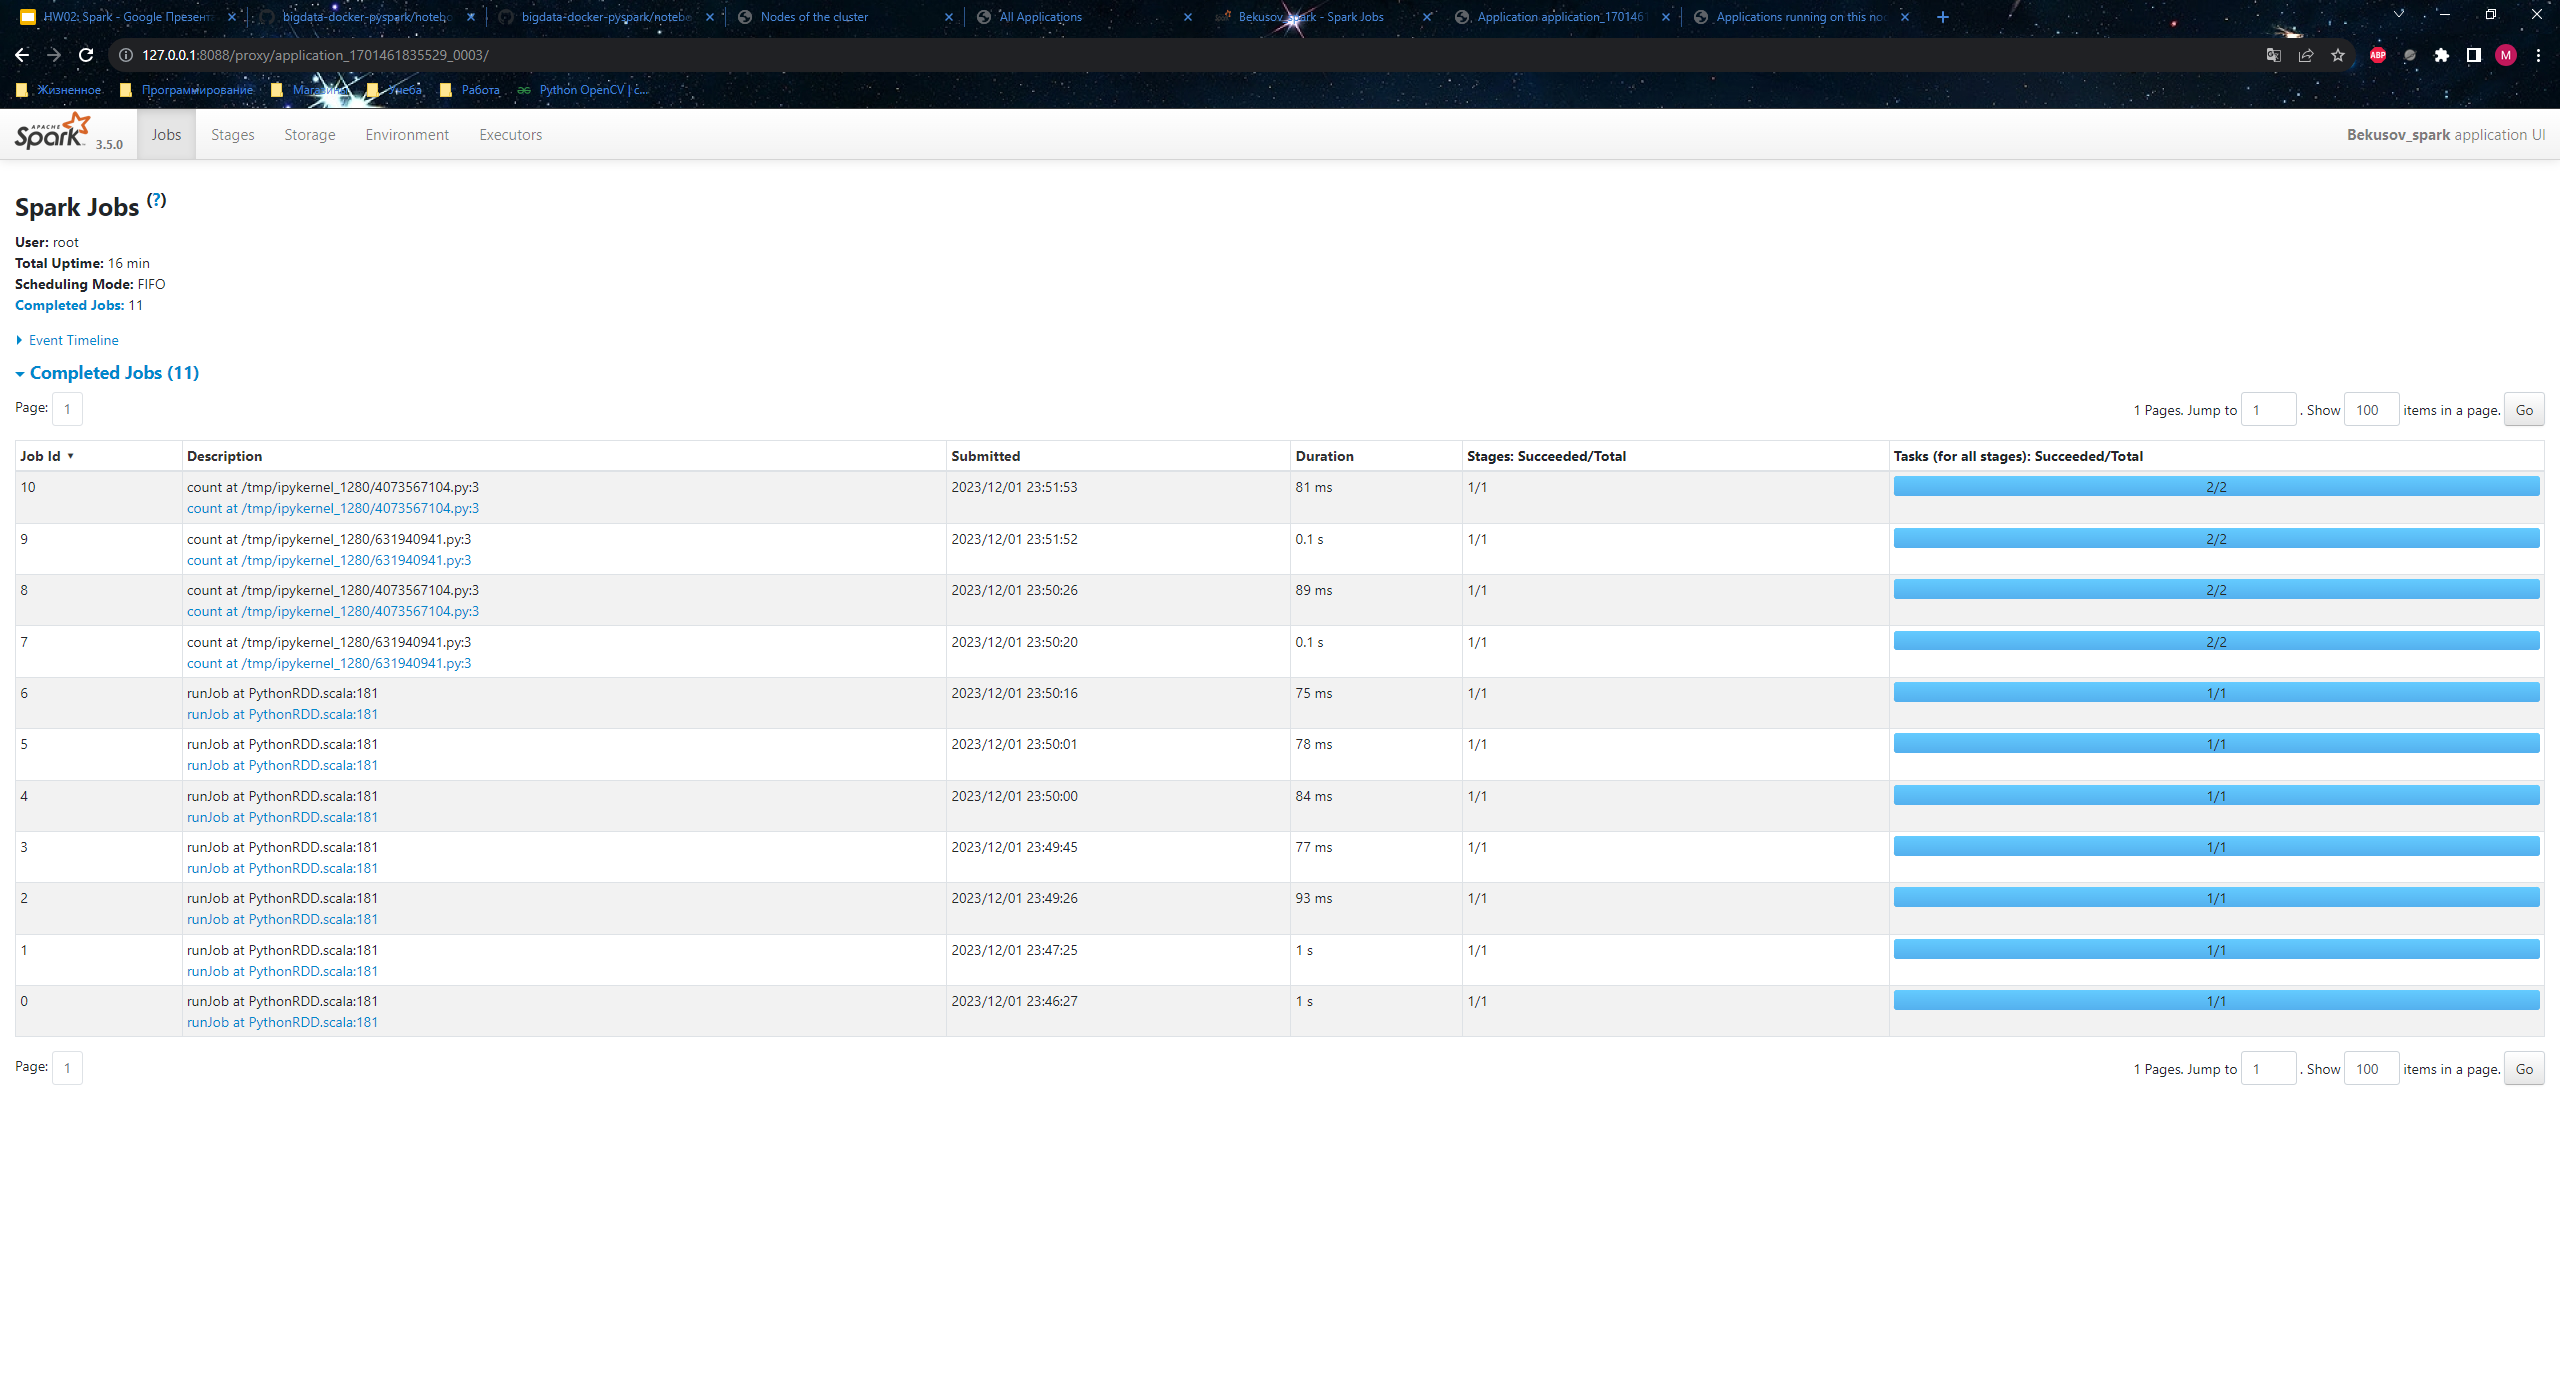

**Для каждой Job'ы было выполнено по одному stage и по два task'а.**  
Суммарно получается 2 stage и 4 таска суммарно.

# Block2 DataWork

Количество уникальных юзеров

In [9]:
ratings_userids = ratings_content.map(lambda x: x.split(",")).map(lambda x: x[0]).distinct()
ratings_userids.count()

610

Количество уникальных фильмов

In [10]:
ratings_movieids = ratings_content.map(lambda x: x.split(",")).map(lambda x: x[1]).distinct()
ratings_movieids.count()

9724

Количество оценок >= 4.0

In [11]:
ratings_content.map(lambda x: x.split(",")).map(lambda x: x[2]).map(lambda x: float(x)).filter(lambda x: x>=4.0).count()

48580

Топ 100 фильмов

In [12]:
movies = sc.textFile("ml-latest-small/movies.csv")
movies_content = movies.filter(lambda x: "movieId" not in x)
movies_data = movies_content.map(lambda x: x.split(",")).map(lambda x: (int(x[0]), x[1]))

In [13]:
sorted_movies = ratings_content.map(lambda x: x.split(",")).map(
    lambda x: (int(x[1]), float(x[2]))
).aggregateByKey(
    (0, 0),
    lambda key, value: (key[0] + value, key[1] + 1),
    lambda key1, key2: (key1[0] + key2[0], key1[1] + key2[1]),
).mapValues(
    lambda x: x[0] / x[1]
)

In [14]:
movies_data.join(sorted_movies).sortBy(
    lambda x: x[1][1], ascending=False
).take(100)

[(8580, ('Into the Woods (1991)', 5.0)),
 (8804, ('"Story of Women (Affaire de femmes', 5.0)),
 (26840, ('Sonatine (Sonachine) (1993)', 5.0)),
 (26928, ('"Summer\'s Tale', 5.0)),
 (27320, ('"Nine Lives of Tomas Katz', 5.0)),
 (27704,
  ('Battle Royale 2: Requiem (Batoru rowaiaru II: Chinkonka) (2003)', 5.0)),
 (34312, ('"Calcium Kid', 5.0)),
 (42556, ('7 Faces of Dr. Lao (1964)', 5.0)),
 (47736, ('"Chump at Oxford', 5.0)),
 (53280, ('"Breed', 5.0)),
 (69860, ('Eichmann (2007)', 5.0)),
 (71268, ("Tyler Perry's I Can Do Bad All by Myself (2009)", 5.0)),
 (72692, ("Mickey's Once Upon a Christmas (1999)", 5.0)),
 (78836, ('Enter the Void (2009)', 5.0)),
 (80124, ('Sisters (Syostry) (2001)', 5.0)),
 (82744, ('Faster (2010)', 5.0)),
 (84512, ('Girls About Town (1931)', 5.0)),
 (86668, ('Louis Theroux: Law & Disorder (2008)', 5.0)),
 (88448, ('Paper Birds (Pájaros de papel) (2010)', 5.0)),
 (93008, ('"Very Potter Sequel', 5.0)),
 (93320, ('Trailer Park Boys (1999)', 5.0)),
 (96608, ('Runaway 

Средняя дельта по времени теггирования и оценки

In [16]:
tags_content.map(lambda x: x.split(",")).map(
    lambda x: (
        int(x[0]),
        int(x[1]),
        int(x[3]),
    )
).take(10)

[(2, 60756, 1445714994),
 (2, 60756, 1445714996),
 (2, 60756, 1445714992),
 (2, 89774, 1445715207),
 (2, 89774, 1445715200),
 (2, 89774, 1445715205),
 (2, 106782, 1445715054),
 (2, 106782, 1445715051),
 (2, 106782, 1445715056),
 (7, 48516, 1169687325)]

In [17]:
ratings = sc.textFile("ml-latest-small/ratings.csv")
ratings_content = ratings.filter(lambda x: "userId" not in x)
ratings_content.map(lambda x: x.split(",")).map(
    lambda x: (
        int(x[0]),
        int(x[1]),
        float(x[2]),
        int(x[3]),
    )
).take(10)

[(1, 1, 4.0, 964982703),
 (1, 3, 4.0, 964981247),
 (1, 6, 4.0, 964982224),
 (1, 47, 5.0, 964983815),
 (1, 50, 5.0, 964982931),
 (1, 70, 3.0, 964982400),
 (1, 101, 5.0, 964980868),
 (1, 110, 4.0, 964982176),
 (1, 151, 5.0, 964984041),
 (1, 157, 5.0, 964984100)]

In [18]:
ratings_content.map(lambda x: x.split(",")).map(
    lambda x: (
        (
            int(x[0]),
            int(x[1]),
        ),
        int(x[3]),
    )
).join(
    tags_content.map(lambda x: x.split(",")).map(
        lambda x: (
            (
                int(x[0]),
                int(x[1]),
            ),
            int(x[3]),
        )
    )
).map(
    lambda x: abs(x[1][0] - x[1][1])
).mean()

29203715.56846947

Средняя оценка по пользователю

In [19]:
ratings_content.map(lambda x: x.split(",")).map(
    lambda x: (
        int(x[0]),
        float(x[2]),
    )
).aggregateByKey(
    (0, 0),
    lambda key, value: (key[0] + value, key[1] + 1),
    lambda key1, key2: (key1[0] + key2[0], key1[1] + key2[1]),
).mapValues(
    lambda x: x[0] / x[1]
).map(
    lambda x: x[1]
).mean()

3.6572223377474007

# Block3 UDF

In [20]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
data = ratings_content.map(lambda x: x.split(",")).map(
    lambda x: (
        (
            int(x[0]),
            int(x[1]),
        ),
        float(x[2]),
    )
).join(
    tags_content.map(lambda x: x.split(",")).map(
        lambda x: (
            (
                int(x[0]),
                int(x[1]),
            ),
            x[2],
        )
    )
).collect()

In [22]:
# tags_words = tags_content.map(lambda x: x.split(",")).map(lambda x: x[2]).map(lambda x: x.split(" ")).flatMap(lambda x: x).collect()
# tags_words = tags_content.map(lambda x: x.split(",")).map(lambda x: x[2]).collect()
# tags_words
tags_words = [x[1][1] for x in data]
len(tags_words)

3476

In [23]:
raitings_sorted_by_tags = [x[1][0] for x in data]
len(raitings_sorted_by_tags)

3476

In [24]:
tfidf = TfidfVectorizer()
tfidf.fit(np.array(tags_words))
tfidf.get_feature_names_out()

array(['06', '1900s', '1920s', ..., 'zombie', 'zombies', 'zooey'],
      dtype=object)

In [25]:
tfidf_data = tfidf.transform(np.array(tags_words))
tfidf_data

<3476x1708 sparse matrix of type '<class 'numpy.float64'>'
	with 5153 stored elements in Compressed Sparse Row format>

In [26]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_data, raitings_sorted_by_tags, test_size=0.2, random_state=42)

In [27]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

SGDRegressor()

In [28]:
display("MAE: ", mean_absolute_error(y_test, sgd.predict(X_test)))
display("MSE: ", mean_squared_error(y_test, sgd.predict(X_test)))

'MAE: '

0.7601752293700302

'MSE: '

0.8709280066613904

In [29]:
ratings_schema = StructType(
    fields=[
        StructField("userId", IntegerType()),
        StructField("movieId", IntegerType()),
        StructField("rating", DoubleType()),
        StructField("timestamp", LongType()),
    ]
)
tags_schema = StructType(
    [
        StructField("userId", IntegerType(), True),
        StructField("movieId", IntegerType(), True),
        StructField("tag", StringType(), True),
        StructField("timestamp", LongType(), True),
    ]
)

In [30]:
spark = SparkSession.builder.config(conf=conf).master(master="yarn").getOrCreate()
tags_df = spark.read.csv("ml-latest-small/tags.csv", header=True, schema=tags_schema)
tags_df.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [31]:
@functions.pandas_udf(DoubleType())
def predict_rating_by_tag(tags):
    return tags.apply(lambda x: sgd.predict(tfidf.transform([x]))[0])

In [32]:
%%time
tags_df.withColumn("rating_predict", predict_rating_by_tag(functions.col("tag"))).collect()

CPU times: user 11.7 ms, sys: 3.75 ms, total: 15.4 ms
Wall time: 2.13 s


[Row(userId=2, movieId=60756, tag='funny', timestamp=1445714994, rating_predict=4.485380800035118),
 Row(userId=2, movieId=60756, tag='Highly quotable', timestamp=1445714996, rating_predict=3.949156942230819),
 Row(userId=2, movieId=60756, tag='will ferrell', timestamp=1445714992, rating_predict=4.015531953221623),
 Row(userId=2, movieId=89774, tag='Boxing story', timestamp=1445715207, rating_predict=3.9942346645121525),
 Row(userId=2, movieId=89774, tag='MMA', timestamp=1445715200, rating_predict=3.411401721907288),
 Row(userId=2, movieId=89774, tag='Tom Hardy', timestamp=1445715205, rating_predict=3.838037431314946),
 Row(userId=2, movieId=106782, tag='drugs', timestamp=1445715054, rating_predict=4.319413937619329),
 Row(userId=2, movieId=106782, tag='Leonardo DiCaprio', timestamp=1445715051, rating_predict=4.145159727595075),
 Row(userId=2, movieId=106782, tag='Martin Scorsese', timestamp=1445715056, rating_predict=3.9069422457059417),
 Row(userId=7, movieId=48516, tag='way too long

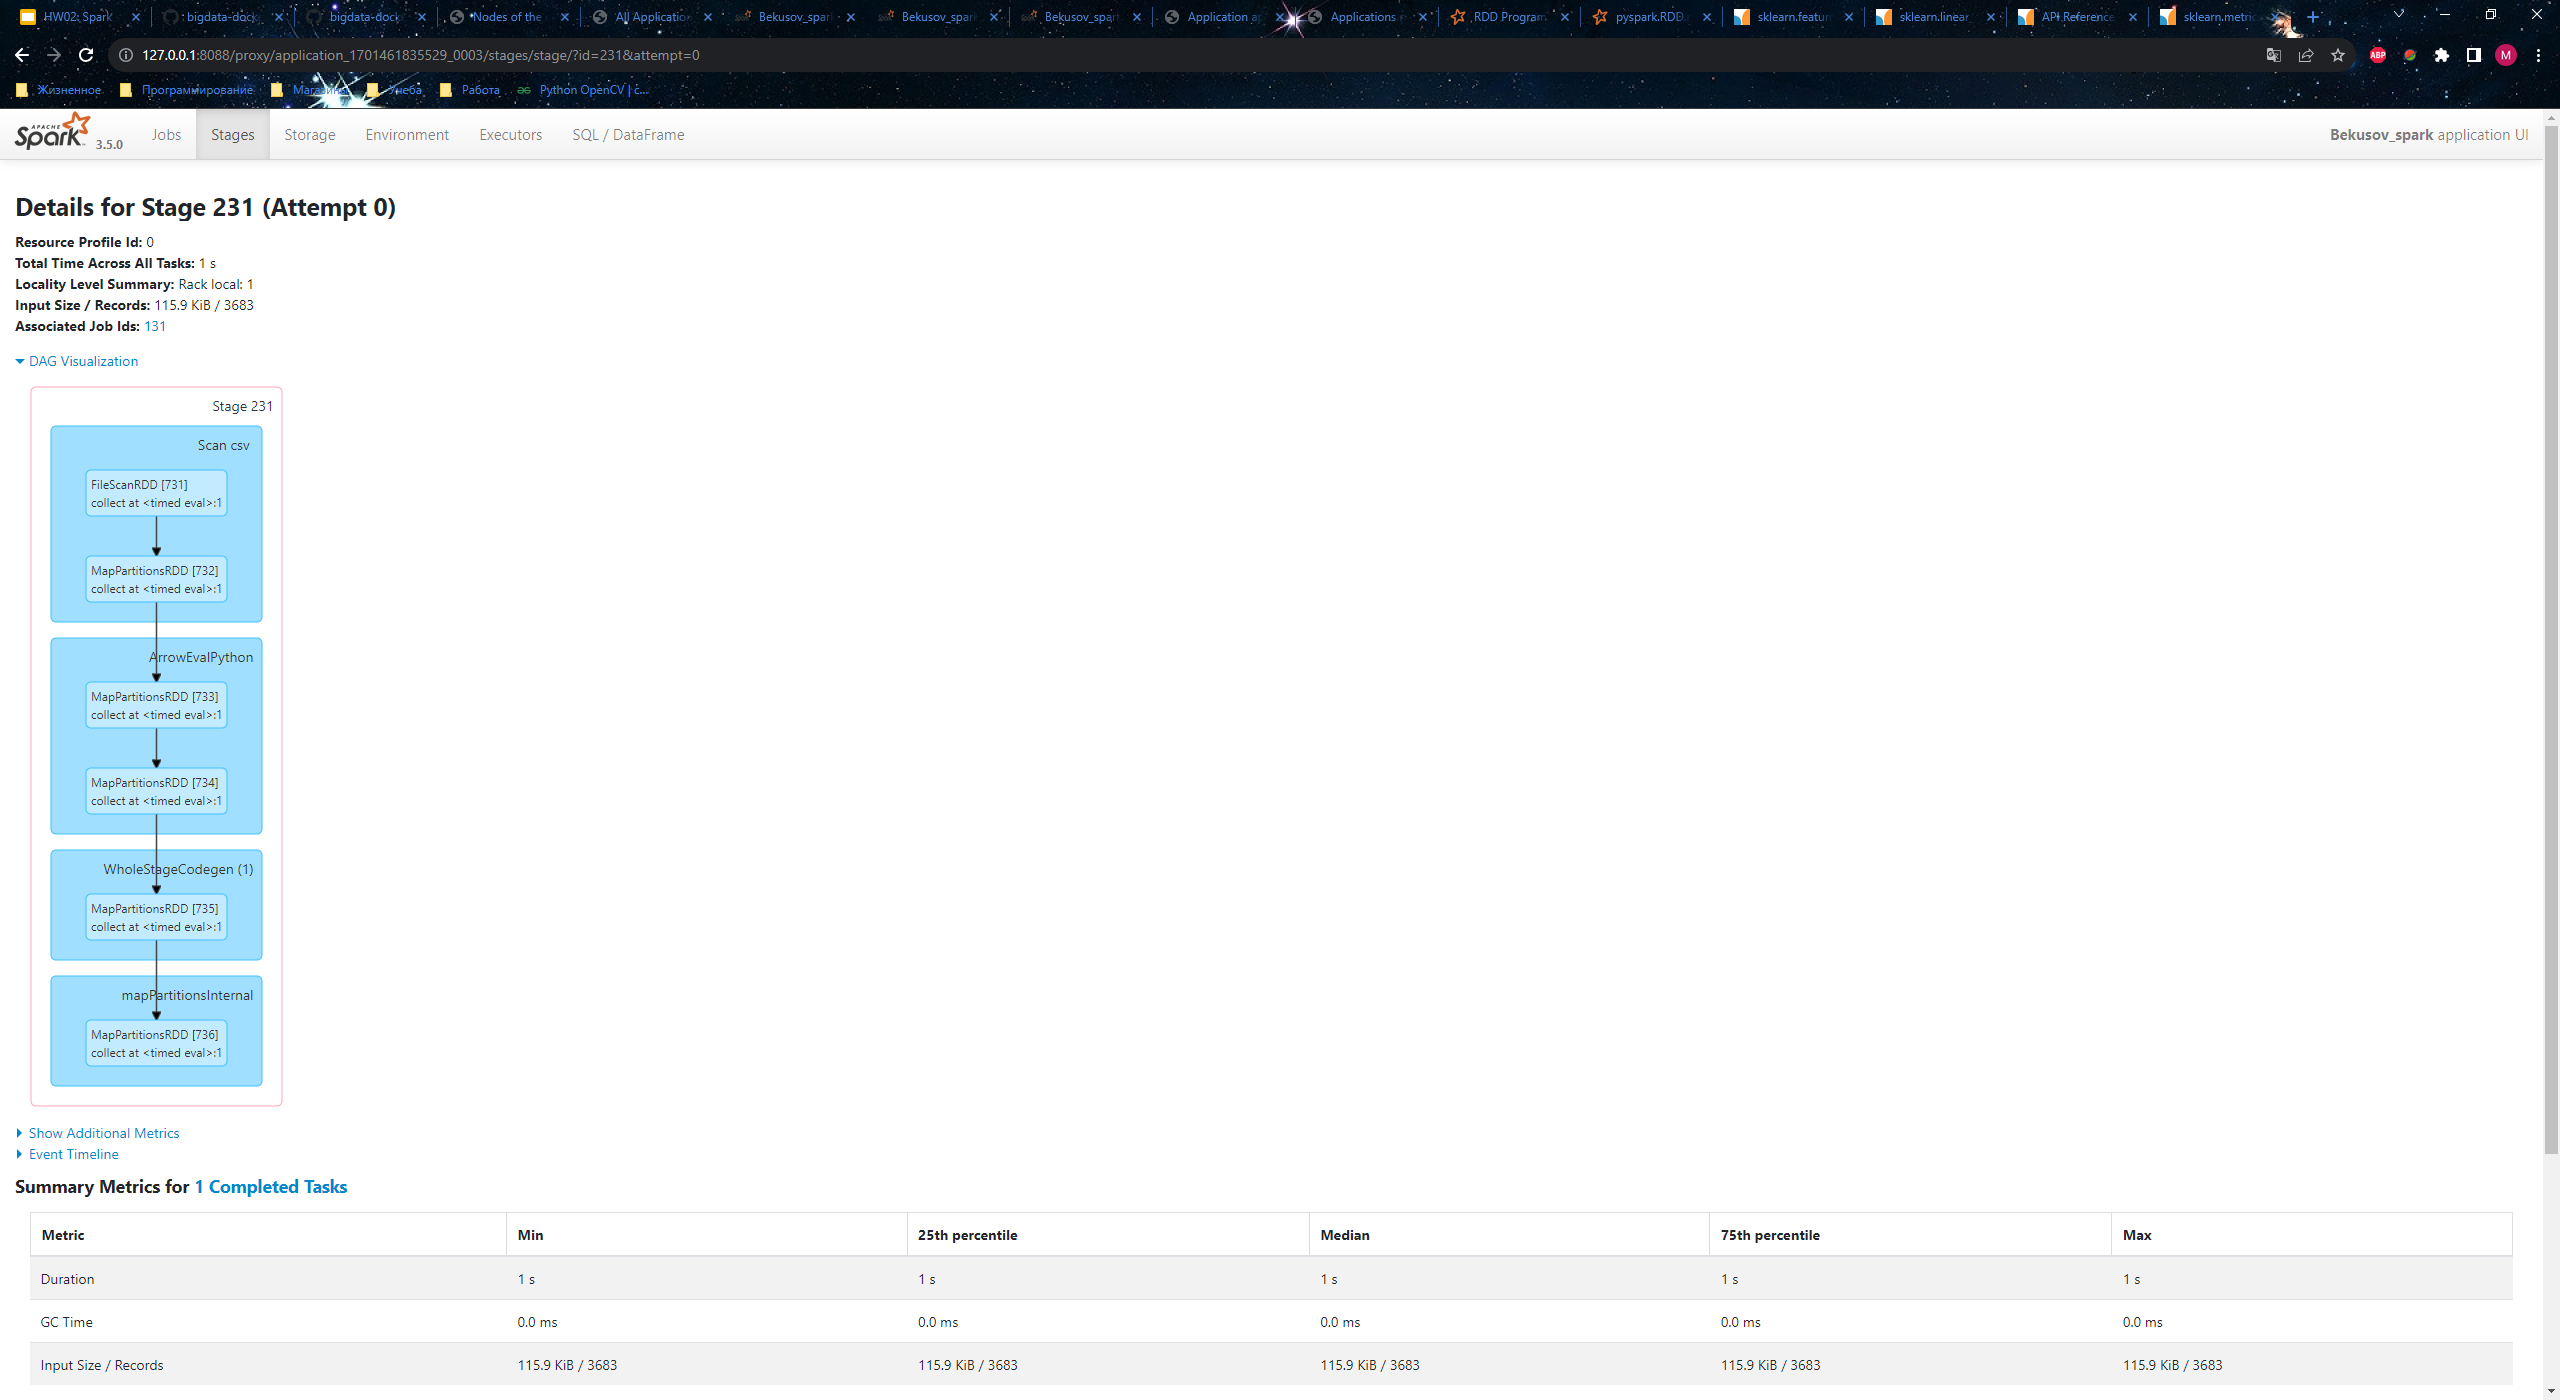

In [33]:
%%time
tags_df_with_preds = spark.read.csv("ml-latest-small/tags.csv", header=True, schema=tags_schema).withColumn("rating_predict", predict_rating_by_tag(functions.col("tag")))

CPU times: user 1.29 ms, sys: 2.42 ms, total: 3.71 ms
Wall time: 29.5 ms


In [34]:
tags_df_with_preds.show()

+------+-------+-----------------+----------+------------------+
|userId|movieId|              tag| timestamp|    rating_predict|
+------+-------+-----------------+----------+------------------+
|     2|  60756|            funny|1445714994| 4.485380800035118|
|     2|  60756|  Highly quotable|1445714996| 3.949156942230819|
|     2|  60756|     will ferrell|1445714992| 4.015531953221623|
|     2|  89774|     Boxing story|1445715207|3.9942346645121525|
|     2|  89774|              MMA|1445715200| 3.411401721907288|
|     2|  89774|        Tom Hardy|1445715205| 3.838037431314946|
|     2| 106782|            drugs|1445715054| 4.319413937619329|
|     2| 106782|Leonardo DiCaprio|1445715051| 4.145159727595075|
|     2| 106782|  Martin Scorsese|1445715056|3.9069422457059417|
|     7|  48516|     way too long|1169687325| 3.424106475553461|
|    18|    431|        Al Pacino|1462138765|3.4109029622357268|
|    18|    431|         gangster|1462138749| 3.538860774199194|
|    18|    431|         

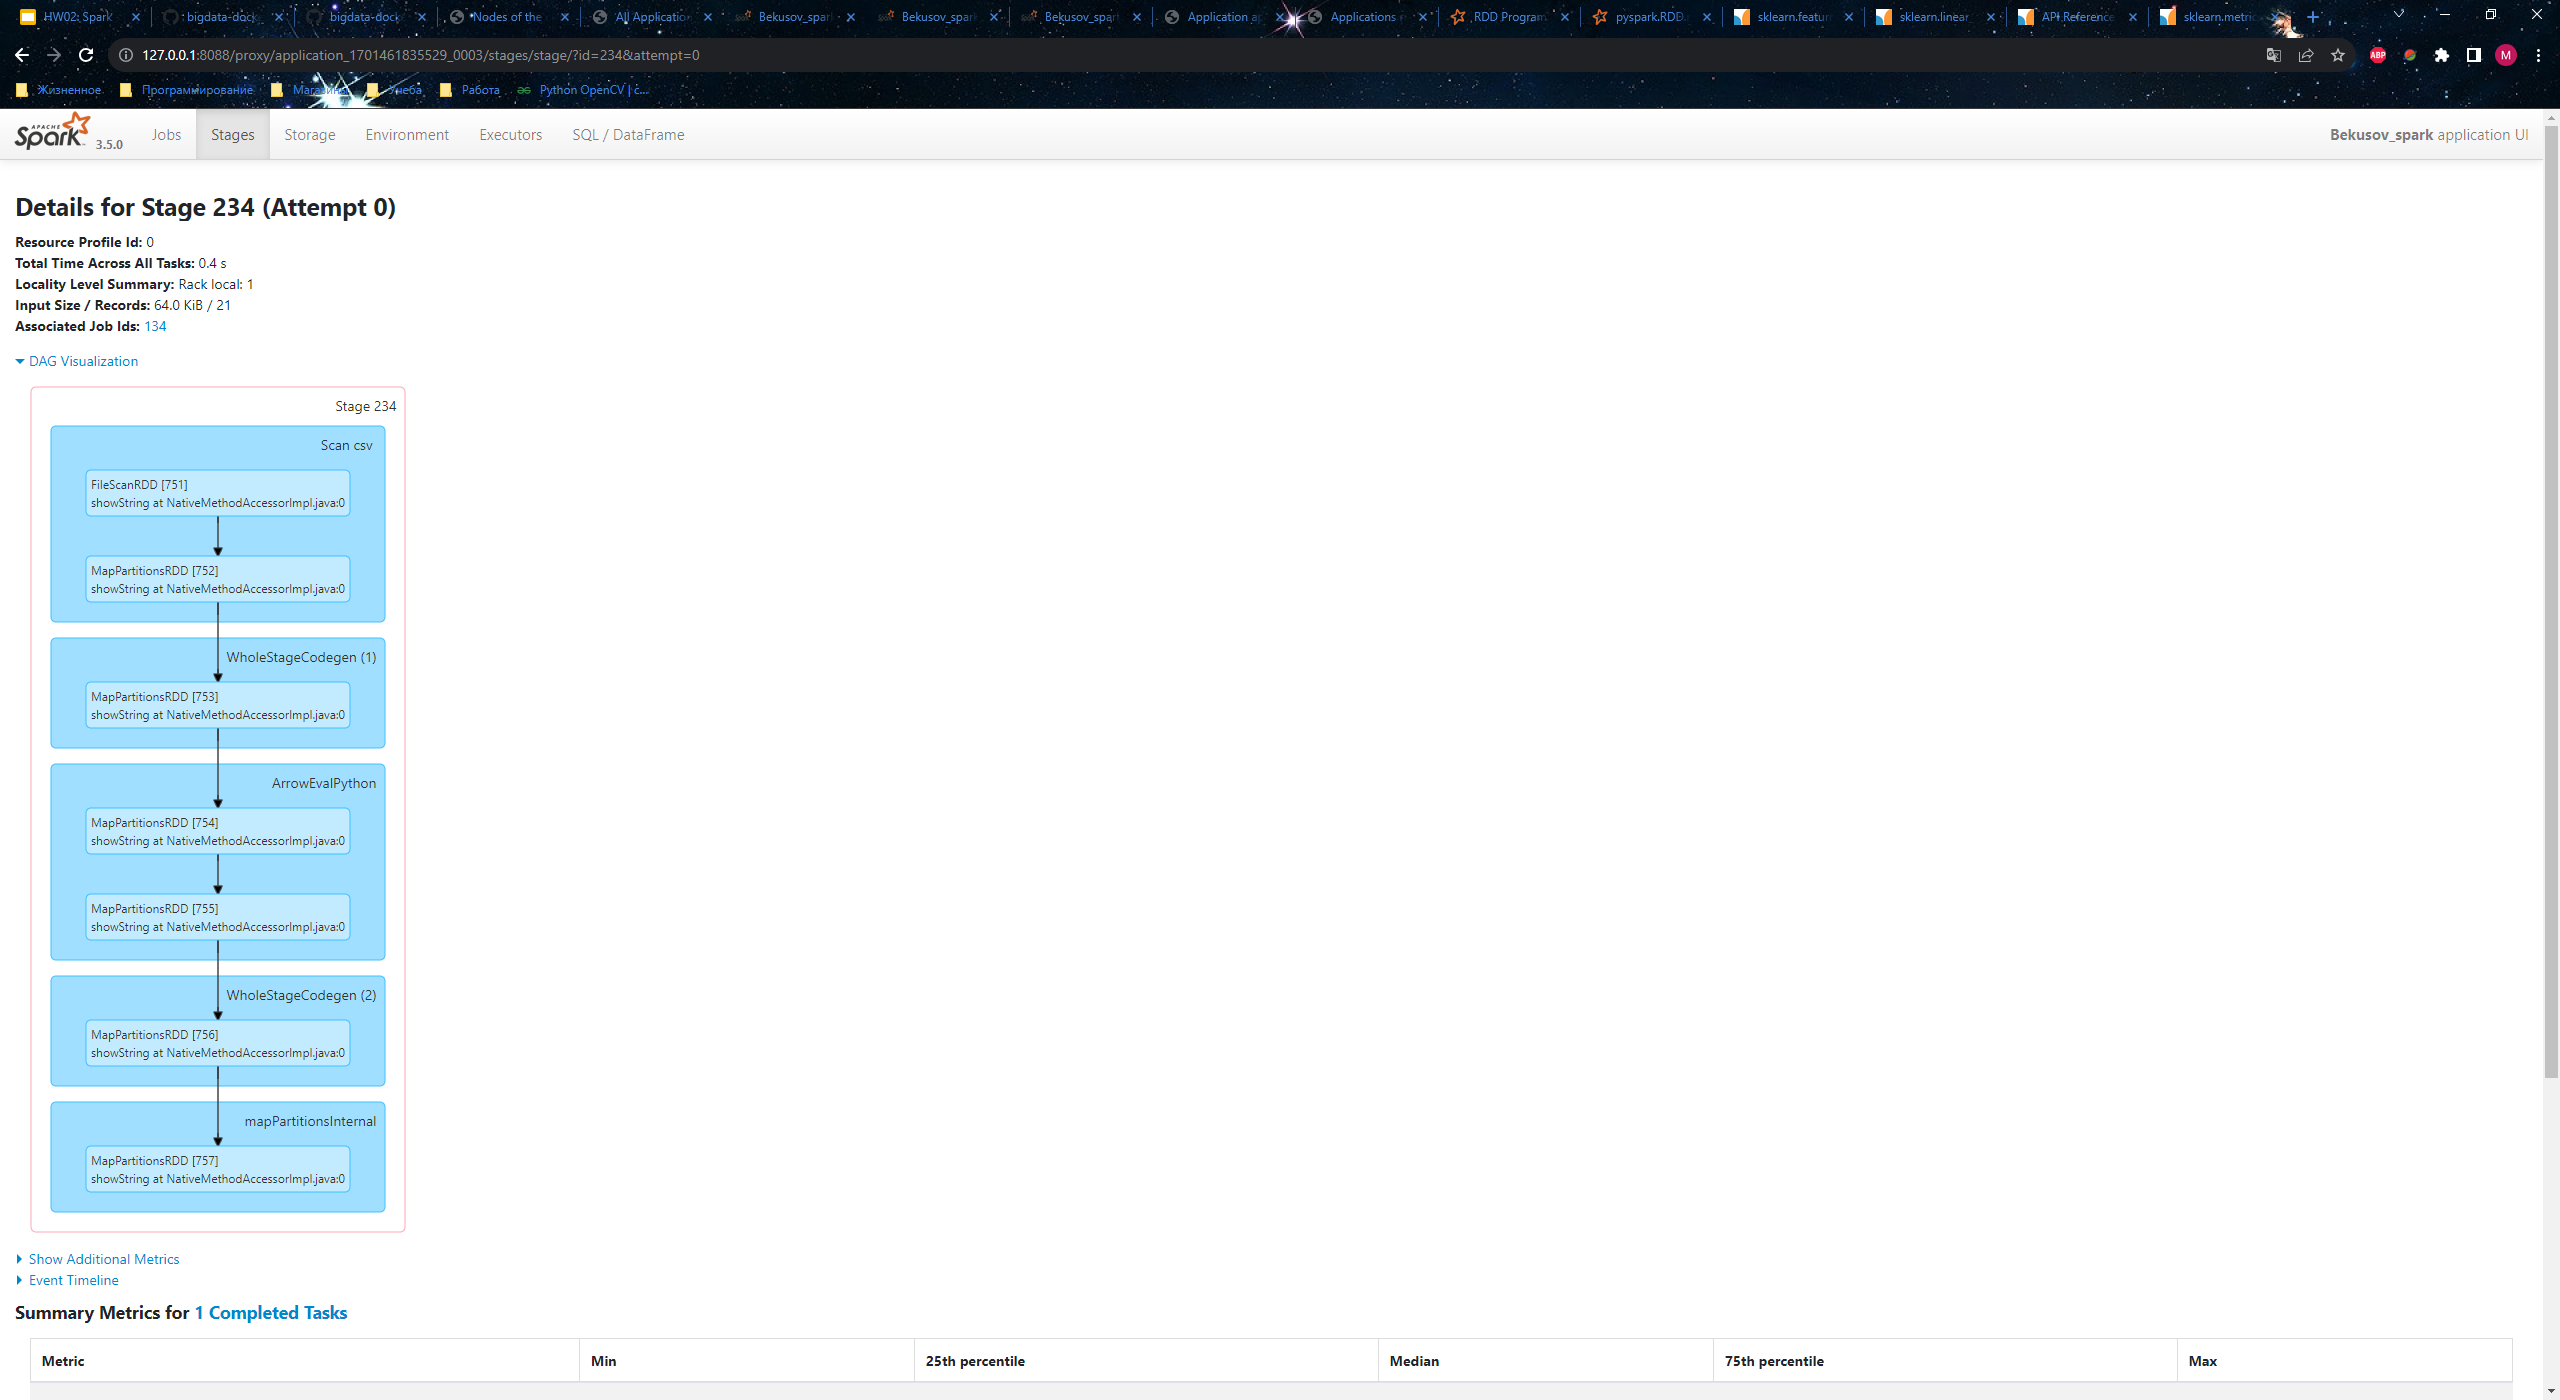

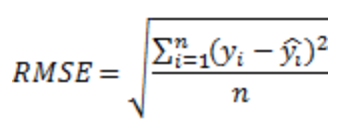

In [35]:
spark.read.csv(
    "ml-latest-small/tags.csv", header=True, schema=tags_schema
).withColumn(
    "rating_predict", predict_rating_by_tag(functions.col("tag"))
).join(
    spark.read.csv(
        "ml-latest-small/ratings.csv", header=True, schema=ratings_schema
    ),
    ["userId", "movieId"],
).select(
    ["rating_predict", "rating"]
).withColumn(
    "error", functions.expr("rating_predict - rating")
).withColumn(
    "sqr_error", functions.expr("error * error")
).select(
    "sqr_error"
).agg(
    functions.avg("sqr_error").alias("mean_sqr_error")
).select(
    "mean_sqr_error", functions.sqrt("mean_sqr_error").alias("rmse")
).show()

+------------------+------------------+
|    mean_sqr_error|              rmse|
+------------------+------------------+
|0.8018500882793875|0.8954608245363879|
+------------------+------------------+



In [ ]:
tags_df_predicted = spark.read.csv(
    "ml-latest-small/tags.csv", header=True, schema=tags_schema
).withColumn("rating_predict", predict_rating_by_tag(functions.col("tag")))
ratings_df = spark.read.csv(
    "ml-latest-small/ratings.csv", header=True, schema=ratings_schema
)

Как бы то не было странным у меня генерируется три джобы (2 - showString at < unknown >:0, 1 - $anonfun$withThreadLocalCaptured$1 at FutureTask.java:266), у каждой из которых по одной таске и одному stage

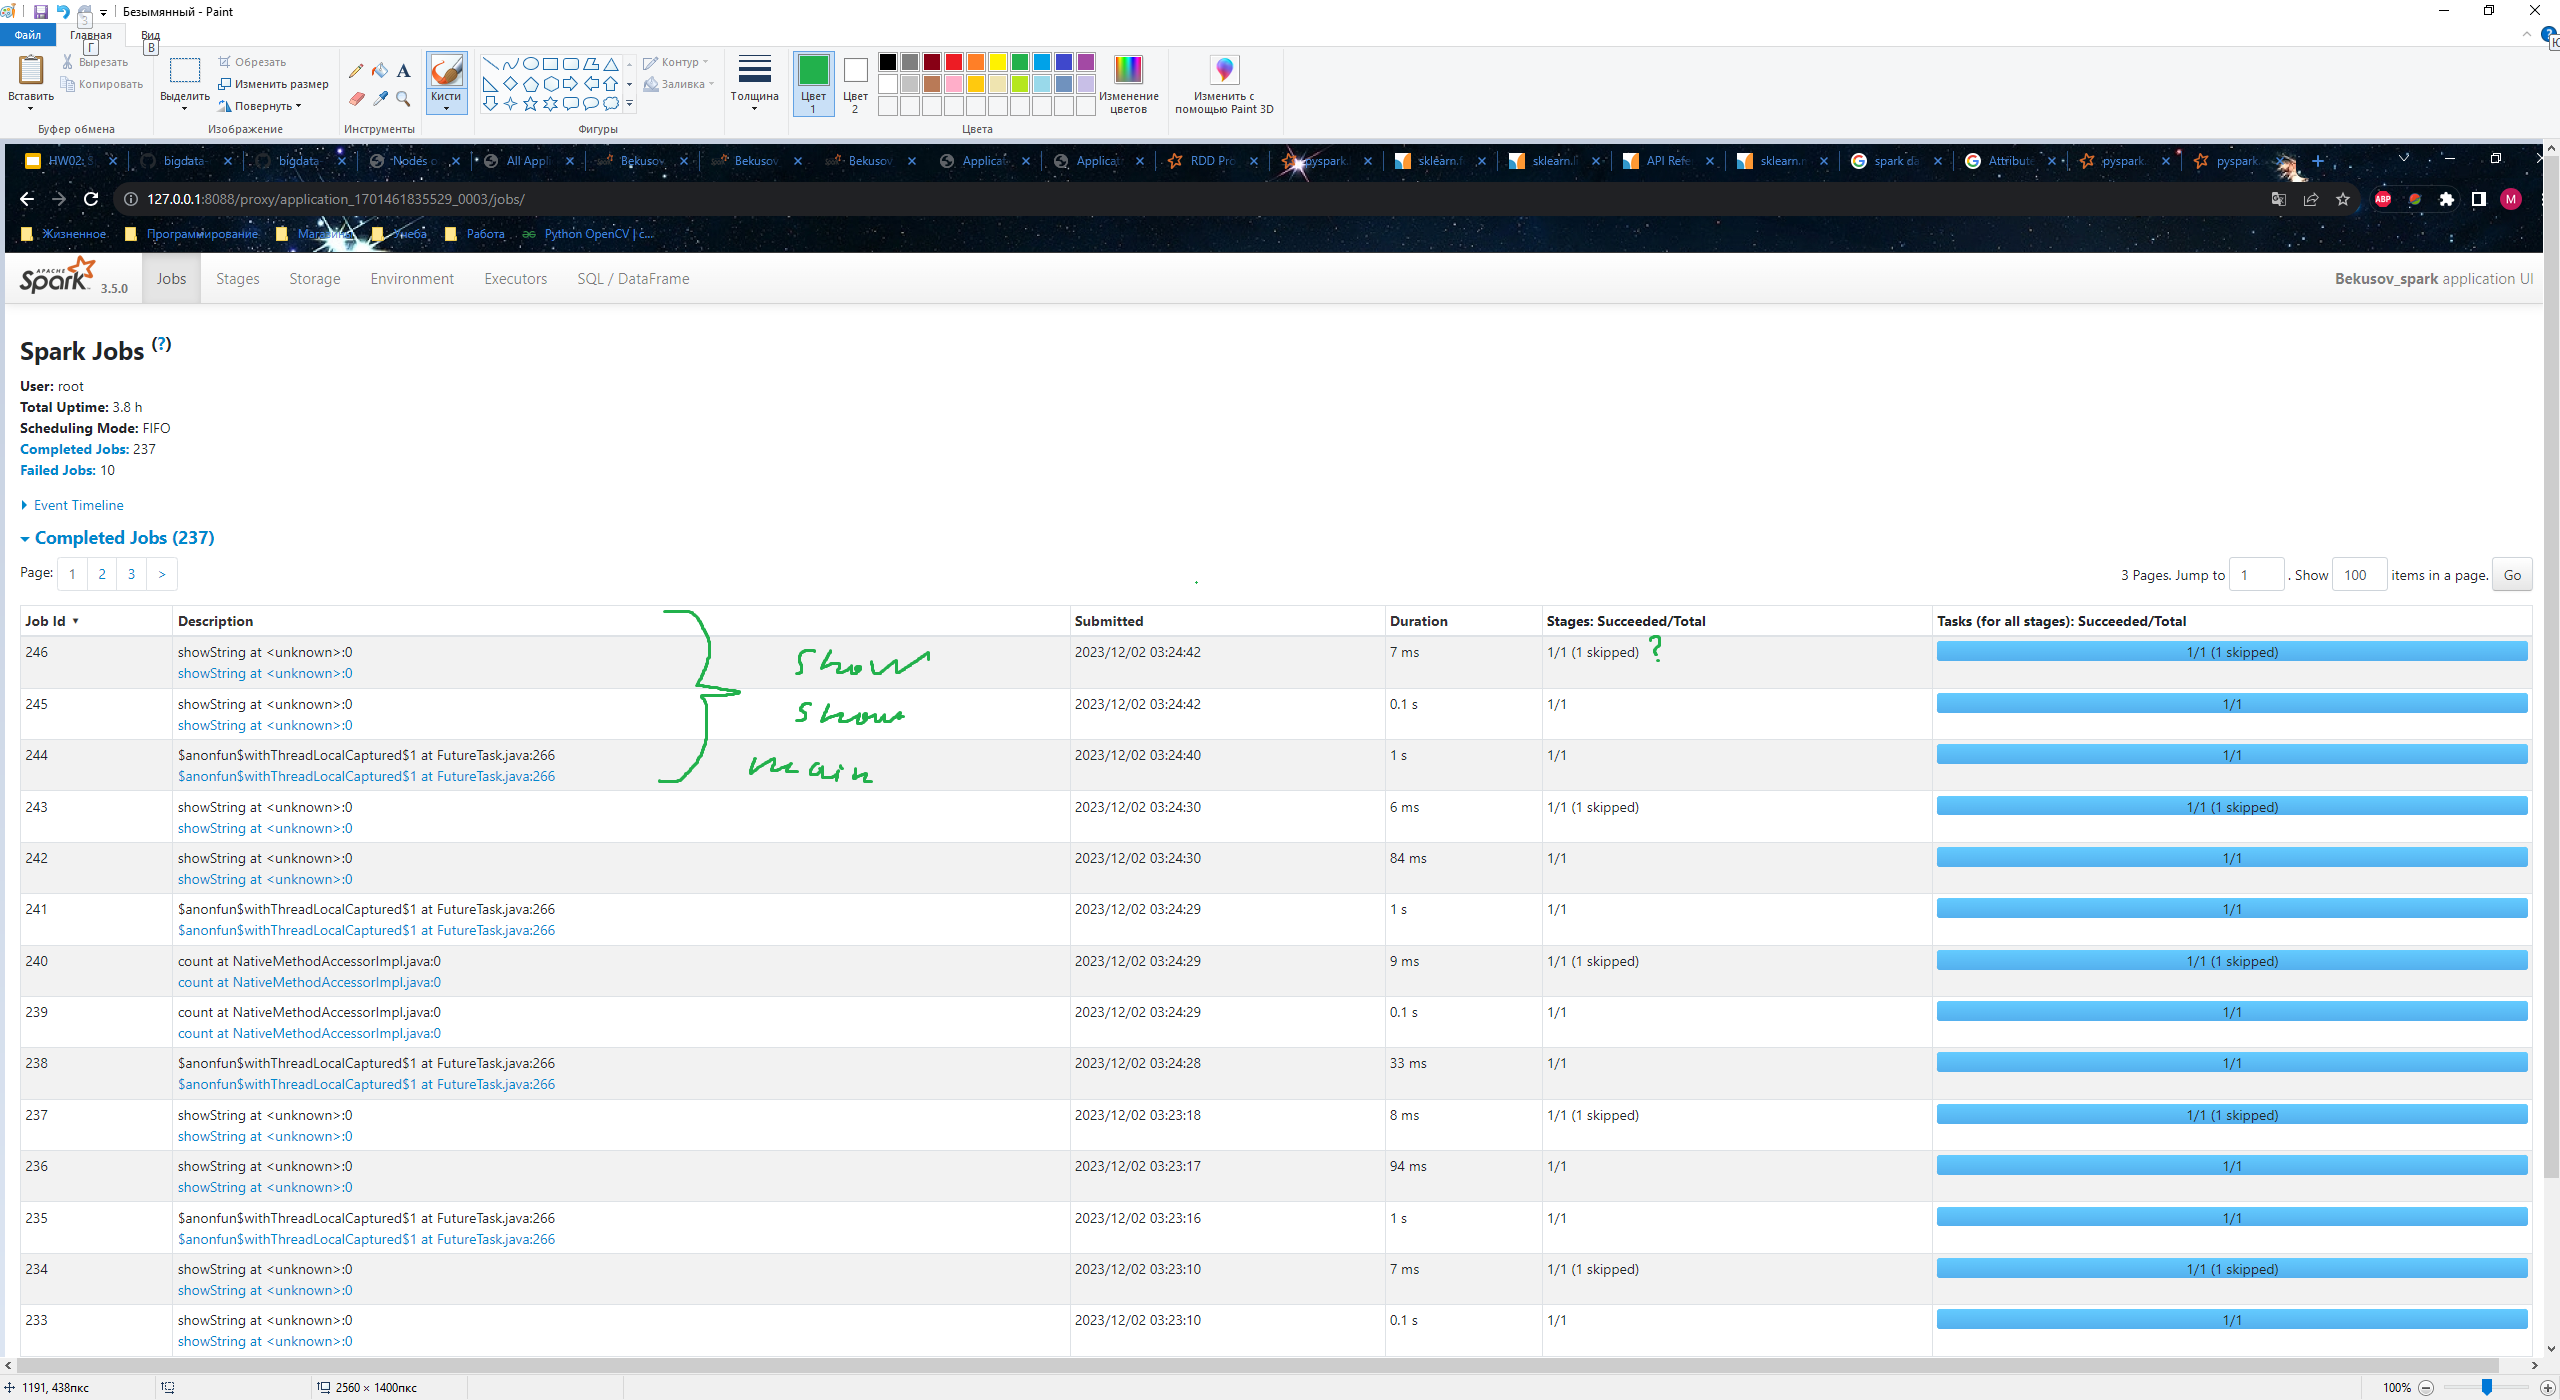